In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functions_NLM import estimate_nested_logit, simulate_choice
from functions_geom_DIB import geom_DIB_on_alternatives

In [2]:
# Load data
data = pd.read_csv('../data/optima.dat', sep='\t')

# Remove missing values, i.e. choice = -1
data = data[data['Choice'] != -1]

In [3]:
# display every column of the dataframe
pd.set_option('display.max_columns', None)
data

ID  DestAct  NbTransf  TimePT  WalkingTimePT  WaitingTimePT  \
0     10350017        2         4      85             23             10   
2     10350025       11         2      82             33              5   
3     10350075        1         3     107             21             31   
4     10350085        1         5     190            116             18   
5     10350086        1         4     116             38             29   
...        ...      ...       ...     ...            ...            ...   
2259  96040531        1         4     148             28             69   
2261  96040537        8         0     139            116              0   
2262  96040537        8         0      71             57              0   
2263  96040538       11         2     118             70             10   
2264  96040538        1         3     140             53             23   

      CostPT  CostCar  TimeCar  NbHousehold  NbChild  NbCar  NbMoto  NbBicy  \
0       12.4     3.17       32            2        0      1       0       3   
2        3.0     0.45        6           -1       -1     -1      -1      -1   
3       24.0     2.36       23            2        0      1       0       0   
4       10.8     1.16       14            3        0      2       0       3   
5        9.6     1.89       20            3        0      2       0       3   
...      ...      ...      ...          ...      ...    ...     ...     ...   
2259    10.4     3.92       40            5        2      1       1       4   
2261    14.4     3.18       43            5        0      2       1       1   
2262     6.0     0.94       12            5        0      2       1       1   
2263    11.4     1.77       24            5        0      2       1       1   
2264    12.6     2.23       28            5        0      2       1       1   

      NbBicyChild  NbComp  NbTV  Internet  NewsPaperSubs  NbCellPhones  \
0               0       2     1         1              2             2   
2              -1      -1    -1        -1             -1            -1   
3               0       1     2         1              1             2   
4               0       1     2         1              2             2   
5               0       1     2         1              2             3   
...           ...     ...   ...       ...            ...           ...   
2259            2       1     1         1              1             2   
2261            0       2     1         1              2             5   
2262            0       2     1         1              2             5   
2263            0       2     1         1              2             5   
2264            0       2     1         1              2             5   

      NbSmartPhone  HouseType  OwnHouse  NbRoomsHouse  YearsInHouse  Income  \
0                2          1         2           5.0             1       4   
2               -1         -1        -1          -1.0            -1      -1   
3                0          1         1           5.0            29       2   
4                0          1         1           4.0            22       4   
5                0          1         1           4.0            22       4   
...            ...        ...       ...           ...           ...     ...   
2259             0          1         2           7.0            16       2   
2261             0          1         1           7.0            23       4   
2262             0          1         1           7.0            23       4   
2263             0          1         1           7.0            23       4   
2264             0          1         1           7.0            23       4   

      Gender  BirthYear  Mothertongue  FamilSitu  OccupStat  SocioProfCat  \
0          1       1983             2          2          3             3   
2         -1         -1            -1         -1         -1            -1   
3          2       1947             2          2          2             4   
4          1    

In [4]:
data_used = data[['ID', 'TimePT', 'WalkingTimePT', 'WaitingTimePT', 'MarginalCostPT', 'TimeCar',
                   'CostCarCHF', 'ReportedDuration', 'Choice']]

In [5]:
data_used

ID  TimePT  WalkingTimePT  WaitingTimePT  MarginalCostPT  TimeCar  \
0     10350017      85             23             10             0.0       32   
2     10350025      82             33              5             3.0        6   
3     10350075     107             21             31            24.0       23   
4     10350085     190            116             18            10.8       14   
5     10350086     116             38             29             9.6       20   
...        ...     ...            ...            ...             ...      ...   
2259  96040531     148             28             69            10.4       40   
2261  96040537     139            116              0            14.4       43   
2262  96040537      71             57              0             6.0       12   
2263  96040538     118             70             10            11.4       24   
2264  96040538     140             53             23            12.6       28   

      CostCarCHF  ReportedDuration  Choice  
0           4.54               255       1  
2           0.64                20       0  
3           3.38                30       1  
4           1.66                20       1  
5           2.71                30       1  
...          ...               ...     ...  
2259        5.62                35       1  
2261        4.56                70       1  
2262        1.35                20       1  
2263        2.54                30       1  
2264        3.20                40       1  

[1906 rows x 9 columns]

In [6]:
# beta_names = ["ASC_private", "ASC_soft", "BETA_Time", "BETA_Cost", "lambda_PT_private",
#                "lambda_private_soft", "base_alpha_private_WITH_PT"]

# DEFINE MODEL STRUCTURE AND LIKELIHOOD FUNCTION
def log_likelihood_optima_CNLM(beta, data):
    alpha_private_WITH_PT = np.exp(beta[6]) / (1 + np.exp(beta[6]))
    alpha_private_WITH_soft = 1 - alpha_private_WITH_PT

    # define utility functions
    data['U_PT'] = beta[2] * (data['TimePT'] + data['WalkingTimePT'] + data['WaitingTimePT']) + \
                    beta[3] * data['MarginalCostPT']
    data['U_private'] = beta[0] + beta[2] * data['TimeCar'] + beta[3] * data['CostCarCHF']
    data['U_soft'] = beta[1] + beta[2] * data['ReportedDuration']

    # combined utility terms inside nests
    data['U_PT_private'] = (alpha_private_WITH_PT * np.exp(data['U_private'])) ** (1 / beta[4]) + \
                          (1 * np.exp(data['U_PT'])) ** (1 / beta[4])
    data['U_private_soft'] = (alpha_private_WITH_soft * np.exp(data['U_private'])) ** (1 / beta[5]) + \
                         (1 * np.exp(data['U_soft'])) ** (1 / beta[5])

    # Nest probabilities
    data['P_nest_PT_private'] = data['U_PT_private'] ** beta[4] / \
                                (data['U_PT_private'] ** beta[4] + data['U_private_soft'] ** beta[5])
    data['P_nest_private_soft'] = 1 - data['P_nest_PT_private']

    # Within nest probabilities for any nests with > 1 alt
    data['P_private_in_PT_private'] = (alpha_private_WITH_PT * np.exp(data['U_private'])) ** (1 / beta[4]) / \
                                    data['U_PT_private'] 
    data['P_PT_in_PT_private'] = 1 - data['P_private_in_PT_private']
    data['P_private_in_private_soft'] = (alpha_private_WITH_soft * np.exp(data['U_private'])) ** (1 / beta[5]) / \
                                data['U_private_soft']
    data['P_soft_in_private_soft'] = 1 - data['P_private_in_private_soft']

    # Full probabilities
    data['P_PT_1'] = data['P_nest_PT_private'] * data['P_PT_in_PT_private']
    data['P_private_2'] = data['P_nest_PT_private'] * data['P_private_in_PT_private'] + \
                          data['P_nest_private_soft'] * data['P_private_in_private_soft']
    data['P_soft_3'] = data['P_nest_private_soft'] * data['P_soft_in_private_soft']

    # calculate probability for chosen alternative for each row in the data table
    data['P'] = ((data['Choice'] == 0) * data['P_PT_1'] +
                 (data['Choice'] == 1) * data['P_private_2'] +
                 (data['Choice'] == 2) * data['P_soft_3'])

    # take product across choices for the same person (likelihood)
    # then take the log for log-likelihood
    LL = data.groupby('ID')['P'].prod().apply(np.log).sum()

    return -LL  # We minimize negative log-likelihood

In [7]:
# Define model parameters
beta = np.array([0, 0, 0, 0, 1, 1, 0])
beta_names = ["ASC_private", "ASC_soft", "BETA_Time", "BETA_Cost", "lambda_PT_private",
              "lambda_private_soft", "base_alpha_private_WITH_PT"]
# Estimate parameters
result, se, t_stat, p_value, aic, bic  = estimate_nested_logit(data_used, beta, beta_names, log_likelihood_optima_CNLM)

/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_25095/1360467015.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['U_PT'] = beta[2] * (data['TimePT'] + data['WalkingTimePT'] + data['WaitingTimePT']) + \
/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_25095/1360467015.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['U_private'] = beta[0] + beta[2] * data['TimeCar'] + beta[3] * data['CostCarCHF']
/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_25095/13604670

Optimization Results:
                    Parameter  Estimate  Robust Asymptotic SE  t-statistic  \
0                 ASC_private  0.225043              0.061129     3.681433   
1                    ASC_soft -1.254924              0.123325   -10.175713   
2                   BETA_Time -0.003122              0.000368    -8.476287   
3                   BETA_Cost -0.041594              0.006033    -6.894747   
4           lambda_PT_private  0.666740              0.053020    12.575190   
5         lambda_private_soft -0.031809              0.020331    -1.564553   
6  base_alpha_private_WITH_PT  1.195636              0.131738     9.075870   

        p-value  
0  2.384029e-04  
1  0.000000e+00  
2  0.000000e+00  
3  7.319700e-12  
4  0.000000e+00  
5  1.178544e-01  
6  0.000000e+00  
AIC: 2731.982779831744
BIC: 2770.852114421243
Log-likelihood: -1358.991389915872


/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_25095/1360467015.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['U_PT_private'] = (alpha_private_WITH_PT * np.exp(data['U_private'])) ** (1 / beta[4]) + \
/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_25095/1360467015.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['U_private_soft'] = (alpha_private_WITH_soft * np.exp(data['U_private'])) ** (1 / beta[5]) + \
/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel

In [8]:
df_input = data[['TimePT', 'MarginalCostPT', 'TimeCar', 'CostCarCHF', 'ReportedDuration']]
# Calculate frequencies and probabilities
vector_counts = df_input.value_counts().reset_index(name='Frequency')
vector_counts['Probability'] = vector_counts['Frequency'] / len(df_input)

# Creating a tuple of attributes to facilitate mapping
vector_counts['tuple'] = vector_counts[['TimePT', 'MarginalCostPT', 'TimeCar', 'CostCarCHF',
                                         'ReportedDuration']].apply(tuple, axis=1)
probability_map = vector_counts.set_index('tuple')['Probability'].to_dict()

# Assign the probability to each row based on its tuple of attributes
df_input['Probability'] = df_input.apply(lambda row: probability_map[tuple(row)], axis=1)


/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_25095/1679802737.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input['Probability'] = df_input.apply(lambda row: probability_map[tuple(row)], axis=1)


In [9]:
# Computation of p(x,y)
p_x = df_input['Probability'].values

p_y_given_x = data_used[['P_PT_1', 'P_private_2', 'P_soft_3']].values
p_xy = p_x[:, np.newaxis] * p_y_given_x

# Normalize p_xy 
p_xy /= p_xy.sum()

# Define epsilon value
epsilon = 1e-20

# Add epsilon to elements equal to 0
p_xy[p_xy == 0] += epsilon

In [10]:
def simulate_choice_optima(row):
    """
    Function to simulate a choice based on cumulative probabilities.

    Parameters:
    - row: pandas Series or DataFrame row containing probabilities for each choice

    Returns:
    - The simulated choice (an integer between 1 and the number of choices)
    """
    # Generate a random number between 0 and 1
    random_number = np.random.rand()
    
    # Calculate cumulative probabilities
    probabilities = row[['P_PT_1', 'P_private_2', 'P_soft_3']]
    cumulative_probs = probabilities.cumsum()
    
    # Determine simulated choice based on random number
    for i, cumulative_prob in enumerate(cumulative_probs):
        if random_number <= cumulative_prob:
            return i+1

In [11]:
np.random.seed(123)
data_used['simulated_choice'] = data_used.apply(simulate_choice_optima, axis=1)
data_used

/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_25095/2856924636.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_used['simulated_choice'] = data_used.apply(simulate_choice_optima, axis=1)


ID  TimePT  WalkingTimePT  WaitingTimePT  MarginalCostPT  TimeCar  \
0     10350017      85             23             10             0.0       32   
2     10350025      82             33              5             3.0        6   
3     10350075     107             21             31            24.0       23   
4     10350085     190            116             18            10.8       14   
5     10350086     116             38             29             9.6       20   
...        ...     ...            ...            ...             ...      ...   
2259  96040531     148             28             69            10.4       40   
2261  96040537     139            116              0            14.4       43   
2262  96040537      71             57              0             6.0       12   
2263  96040538     118             70             10            11.4       24   
2264  96040538     140             53             23            12.6       28   

      CostCarCHF  ReportedDuration  Choice      U_PT  U_private    U_soft  \
0           4.54               255       1 -0.368339  -0.063682 -2.050911   
2           0.64                20       0 -0.499364   0.179693 -1.317354   
3           3.38                30       1 -1.494573   0.012660 -1.348570   
4           1.66                20       1 -1.460585   0.112296 -1.317354   
5           2.71                30       1 -0.970539   0.049893 -1.348570   
...          ...               ...     ...       ...        ...       ...   
2259        5.62                35       1 -1.197348  -0.133576 -1.364177   
2261        4.56                70       1 -1.394938  -0.098851 -1.473430   
2262        1.35                20       1 -0.649117   0.131433 -1.317354   
2263        2.54                30       1 -1.092230   0.044478 -1.348570   
2264        3.20                40       1 -1.198330   0.004540 -1.379785   

      U_PT_private  U_private_soft  P_nest_PT_private  P_nest_private_soft  \
0         1.186997    1.003953e+28           0.897081             0.102919   
2         1.353690    1.270438e+18           0.821697             0.178303   
3         0.791923    6.013107e+19           0.784675             0.215325   
4         0.907991    3.478789e+18           0.784767             0.215233   
5         0.958262    2.043619e+19           0.799939             0.200061   
...            ...             ...                ...                  ...   
2259      0.716595    5.714026e+21           0.797597             0.202403   
2261      0.703459    2.047488e+21           0.790238             0.209762   
2262      1.197061    2.344073e+18           0.812355             0.187645   
2263      0.913484    2.374921e+19           0.795562             0.204438   
2264      0.843082    8.117971e+19           0.793214             0.206786   

      P_private_in_PT_private  P_PT_in_PT_private  P_private_in_private_soft  \
0                    0.515130            0.484870               6.318748e-08   
2                    0.650690            0.349310               2.374176e-01   
3                    0.865786            0.134214               9.570136e-01   
4                    0.876821            0.123179               7.215084e-01   
5                    0.756591            0.243409               8.735175e-01   
...                       ...                 ...                        ...   
2259                 0.768362            0.231638               9.992611e-01   
2261                 0.824555            0.175445               9.360309e-01   
2262                 0.684450            0.315550               5.866965e-01   
2263                 0.787258            0.212742               8.911618e-01   
2264                 0.803404            0.196596               9.150481e-01   

      P_soft_in_private_soft    P_PT_1  P_private_2  P_soft_3         P  \
0                   1.000000  0.434968     0.462113  0.102919  0.462113   
2                   0.762582  0.287027     0.577003  0.135971  0.2

Iteration: 1 out of 5000
Objective function value: 1.0985322561962754
H(T) =  1.0985322561962754
I(T;Y) =  0.0001207362175390525
Iteration: 2 out of 5000
Objective function value: 0.7945398305073719
H(T) =  0.7945398305073719
I(T;Y) =  2.791184664685531e-05
Iteration: 3 out of 5000
Objective function value: 0.59918609970886
H(T) =  0.59918609970886
I(T;Y) =  1.830559323279246e-05
Iteration: 4 out of 5000
Objective function value: 0.4844786363479665
H(T) =  0.4844786363479665
I(T;Y) =  1.3610708892830559e-05
Iteration: 5 out of 5000
Objective function value: 0.4090347865069352
H(T) =  0.4090347865069352
I(T;Y) =  1.083074433583242e-05
Iteration: 6 out of 5000
Objective function value: 0.35540199322338406
H(T) =  0.35540199322338406
I(T;Y) =  8.993232462506384e-06
Iteration: 7 out of 5000
Objective function value: 0.31515775087830983
H(T) =  0.31515775087830983
I(T;Y) =  7.688564243935048e-06
Iteration: 8 out of 5000
Objective function value: 0.28374694948807716
H(T) =  0.283746949488077

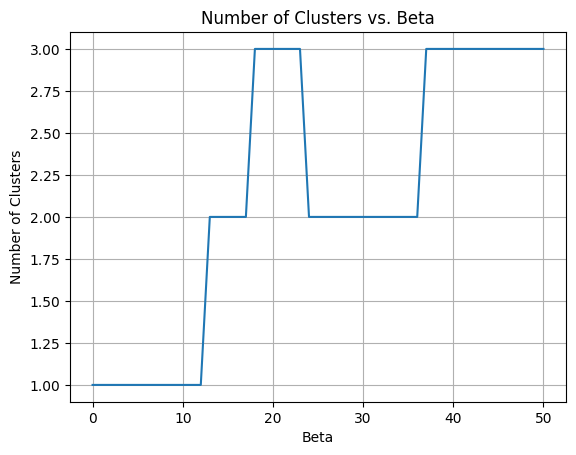

In [12]:
betas = np.linspace(0, 50, 51)
# Initialize an empty list to store the number of clusters
num_clusters_list = []

# Iterate over each beta value
for beta in betas:
    # Run iterative_algorithm to obtain q_t_given_x
    q_t_given_x, _, _ = geom_DIB_on_alternatives(p_xy, max_iter=5000, beta=beta, threshold=1e-4)
    
    # Calculate the number of clusters
    column_sum = np.sum(q_t_given_x, axis=0)
    num_clusters = np.count_nonzero(column_sum)
    
    # Append the number of clusters to the list
    num_clusters_list.append(num_clusters)

# Plot the number of clusters against beta values
plt.plot(betas, num_clusters_list)
plt.xlabel('Beta')
plt.ylabel('Number of Clusters')
plt.title('Number of Clusters vs. Beta')
plt.grid(True)
plt.show()

In [13]:
q_t_given_x, q_t, q_y_given_t = geom_DIB_on_alternatives(p_xy, beta=30, max_iter=5000, threshold=1e-5)

Iteration: 1 out of 5000
Objective function value: 1.0949101696701038
H(T) =  1.0985322561962754
I(T;Y) =  0.0001207362175390525
Iteration: 2 out of 5000
Objective function value: -0.40141525570844816
H(T) =  0.7269970726900322
I(T;Y) =  0.037613744279949346
Iteration: 3 out of 5000
Objective function value: -0.4474028746941392
H(T) =  0.7166492138933824
I(T;Y) =  0.03880173628625072
Iteration: 4 out of 5000
Objective function value: -0.47804175950924455
H(T) =  0.7006075320980587
I(T;Y) =  0.03928830972024344
Iteration: 5 out of 5000
Objective function value: -0.4971311476342999
H(T) =  0.6839094959637704
I(T;Y) =  0.03936802145326901
Iteration: 6 out of 5000
Objective function value: -0.3392636177886683
H(T) =  1.0382334956713495
I(T;Y) =  0.04591657044866726
Iteration: 7 out of 5000
Objective function value: -0.3648053500554256
H(T) =  0.9704580089258368
I(T;Y) =  0.044508778632708745
Iteration: 8 out of 5000
Objective function value: -0.3839361254634197
H(T) =  0.9154840156826707
I

In [14]:
import re

# Define a function to extract the number from the column name
def extract_number(column_name):
    match = re.search(r'\d+', column_name)  # Search for one or more digits in the column name
    if match:
        return int(match.group())  # Return the first occurrence of digits as an integer
    else:
        return None  # Return None if no digits are found

In [15]:
# Calculate the number of clusters
column_sum = np.sum(q_t_given_x, axis=0)
num_clusters = np.count_nonzero(column_sum)
print('Number of clusters :', num_clusters)

# Count the number of observations in each cluster
data_used['cluster'] = np.argmax(q_t_given_x, axis=1)
print('\n', data_used['cluster'].value_counts())

# number of each alternative 1, 2, 3, 4, 5 in each cluster 
cluster_counts = data_used.groupby(['cluster', 'Choice']).size().unstack(fill_value=0)
print('\n', cluster_counts)

data_used['max_proba'] = data_used[['P_PT_1', 'P_private_2', 'P_soft_3']].idxmax(axis=1).apply(extract_number)
cluster_counts2 = data_used.groupby(['cluster', 'max_proba']).size().unstack(fill_value=0)
print('\n', cluster_counts2)

cluster_counts3 = data_used.groupby(['cluster', 'simulated_choice']).size().unstack(fill_value=0)
print('\n', cluster_counts3)

Number of clusters : 2

 cluster
0    1370
1     536
Name: count, dtype: int64

 Choice     0    1    2
cluster               
0        473  785  112
1         63  471    2

 max_proba   1     2
cluster            
0          67  1303
1           0   536

 simulated_choice    1    2   3
cluster                       
0                 464  828  78
1                  65  471   0


/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_25095/2352194042.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_used['cluster'] = np.argmax(q_t_given_x, axis=1)
/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_25095/2352194042.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_used['max_proba'] = data_used[['P_PT_1', 'P_private_2', 'P_soft_3']].idxmax(axis=1).apply(extract_number)
